## KMeans Clustering of Hyperspectral Vegetation 

### standardized spectra at full resolution without spatial dimension

---

In [3]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [4]:
def kmeans_test_dictionary(labels, test, k):
    import collections, numpy
    
    unique_test, counts_test = numpy.unique(labels[test[:,0], test[:,1]], return_counts=True)
    counts_test_norm = (counts_test/test.shape[0])*100
    test_dict = dict(zip(unique_test, counts_test))
    test_dict_norm = dict(zip(unique_test, counts_test_norm))
    
    for i in range(0, k):
        if test_dict.get(i) is None: test_dict[i] = 0
        if test_dict_norm.get(i) is None: test_dict_norm[i] = 0
    
    return test_dict, test_dict_norm

In [5]:
def kmeans_test_dataframe(sky_dict,
                          clouds_dict,
                          veg_dict,
                          wtr_dict,
                          blt_dict,
                          windows_dict,
                          rds_dict,
                          cars_dict,
                          mtl_dict
                         ):
    import pandas as pd
    
    pixel_names = ['sky', 'clouds', 'vegetation', 'water', 'built',
                  'windows', 'roads', 'cars', 'metal']
    df_test = pd.DataFrame([sky_dict,
                            clouds_dict,
                            veg_dict,
                            wtr_dict,
                            blt_dict,
                            windows_dict,
                            rds_dict,
                            cars_dict,
                            mtl_dict], index=pixel_names)
    df_test = df_test.transpose()
    
    return df_test

In [6]:
def plot_confusion_matrix(df_test, norm=True):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cm = np.array([df_test['sky'].values,
                   df_test['clouds'].values,
                   df_test['vegetation'].values,
                   df_test['water'].values,
                   df_test['built'].values,
                   df_test['windows'].values,
                   df_test['roads'].values,
                   df_test['cars'].values,
                   df_test['metal'].values])
    classes = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 
              'cars', 'metal']
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    if norm:
        title='Normalized Confusion Matrix'
        fmt='.2f'
    else:
        title='Confusion Matrix'
        fmt='d'
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=np.arange(0,cm.shape[1]).astype(str), 
          yticklabels=classes,
          title=title,
          ylabel='True Label',
          xlabel='Predicted Label')
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #        rotation_mode="anchor")
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [7]:
def plot_test_result(df_Test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    df_test = df_Test.transpose()
    ax = df_test.plot.bar(rot=0, stacked=True, colormap='tab20b')
                          #color=['tab:blue', 'tab:green', 'tab:gray'])
    plt.xlabel('Actual Class')
    plt.ylabel('%of Test Pixels')
    plt.title('Error in Kmeans Prediction')
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
    plt.show()

In [8]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [9]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

---
### Goal of clustering:
1. Sky
2. Clouds
3. Water
4. Vegetation
5. Buildings (concrete structures)
6. Windows
7. Roads
8. Cars
9. Metal Structures
---


## KMeans on veg_00108 (South Facing @ ~2pm)

In [11]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [12]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [13]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


In [14]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)

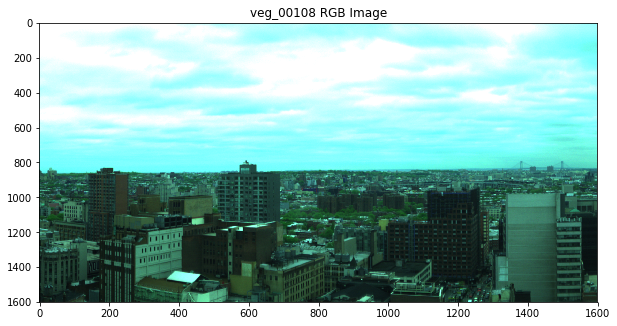

In [15]:
cube_norm = (cube_reshaped - cube_reshaped.min()) / (cube_reshaped.max() - cube_reshaped.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind = (np.abs(cube.waves - 650.0)).argmin()
green_ind = (np.abs(cube.waves - 550.0)).argmin()
blue_ind = (np.abs(cube.waves - 450.0)).argmin()

cube_reshaped2 = cube_norm.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
cube_scene = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 RGB Image')
ax.imshow(cube_scene, aspect=0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


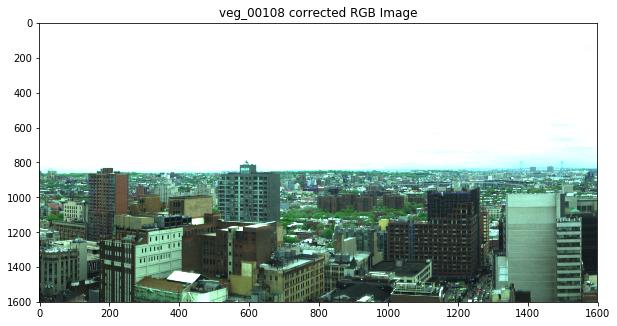

In [16]:
rgb = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]].copy()
rgb /= rgb.mean((0, 1), keepdims=True)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 corrected RGB Image')
ax.imshow(rgb, aspect=0.5)
plt.show()

In [17]:
from sklearn.cluster import MiniBatchKMeans

km = MiniBatchKMeans(n_clusters=9, random_state=2, batch_size=20)

In [18]:
import time
start_time = time.time()

kmeans = km.fit(cube_standard)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:00:48


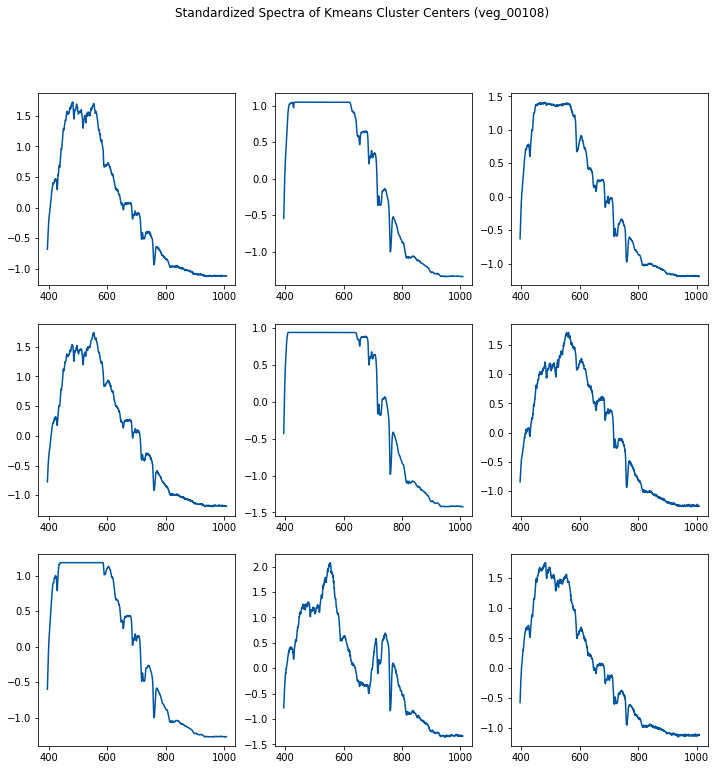

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 12))
plt.suptitle('Standardized Spectra of Kmeans Cluster Centers (veg_00108)')
ax1.plot(cube.waves, kmeans.cluster_centers_[0,:], color=[0.0,0.33,0.62])
ax2.plot(cube.waves, kmeans.cluster_centers_[1,:], color=[0.0,0.33,0.62])
ax3.plot(cube.waves, kmeans.cluster_centers_[2,:], color=[0.0,0.33,0.62])
ax4.plot(cube.waves, kmeans.cluster_centers_[3,:], color=[0.0,0.33,0.62])
ax5.plot(cube.waves, kmeans.cluster_centers_[4,:], color=[0.0,0.33,0.62])
ax6.plot(cube.waves, kmeans.cluster_centers_[5,:], color=[0.0,0.33,0.62])
ax7.plot(cube.waves, kmeans.cluster_centers_[6,:], color=[0.0,0.33,0.62])
ax8.plot(cube.waves, kmeans.cluster_centers_[7,:], color=[0.0,0.33,0.62])
ax9.plot(cube.waves, kmeans.cluster_centers_[8,:], color=[0.0,0.33,0.62])
plt.show()
#f.savefig("./output/plots/13_kmeans_cluster_centers_spectra_standardized_4_clusters.png")

In [21]:
labels = kmeans.predict(cube_standard)
labels_reshape = labels.reshape(cube_sub.shape[1], cube_sub.shape[2])

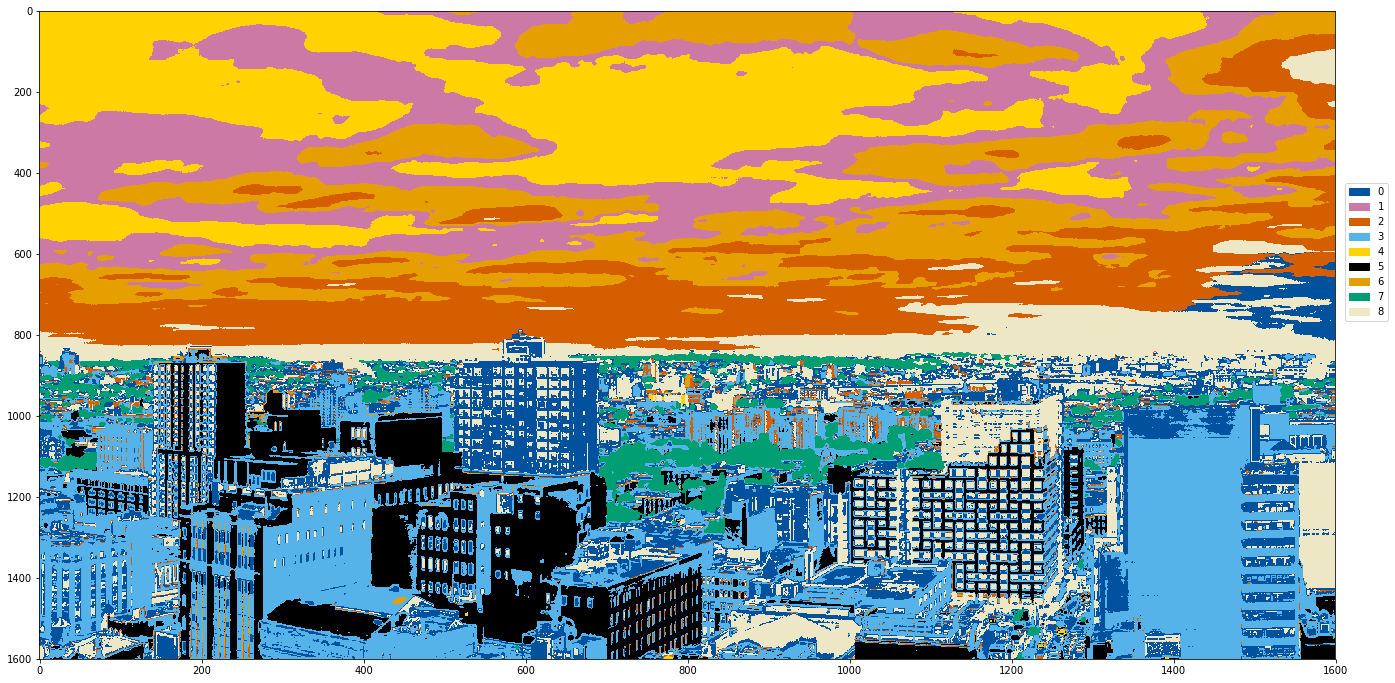

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

t=1
cmap = {0: [0,0.32549,0.62353,1], #sky: UD blue
        1: [0.8,0.47451,0.65490,1],    #metal: reddish purple
        2: [0.83529,0.36863,0,1],   #cars: vermillion
        3: [0.33725,0.70588,0.91373,1], #water: sky blue
        4: [1,0.82353,0,1],#windows: UD Gold
        5: [0,0,0,1], #built: black
        6: [0.90196,0.62353,0,1],  #roads: orange
        7: [0,0.61961,0.45098,1],  #veg: bluish green
        8: [0.93333,0.9098,0.77255,1] #clouds: UD beige
         }
labels = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'10', 11:'11'}
arrayShow = np.array([[cmap[i] for i in j] for j in labels_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(30,10))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', 
                borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./output/plots/19_kmeans_clustering_of_veg_00108.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [30]:
veg_by_row = np.zeros(cube_sub.shape[1])
for row in range(0, cube_sub.shape[1]):
    veg_by_row[row] = np.count_nonzero(labels_reshape[row,:] == 7)

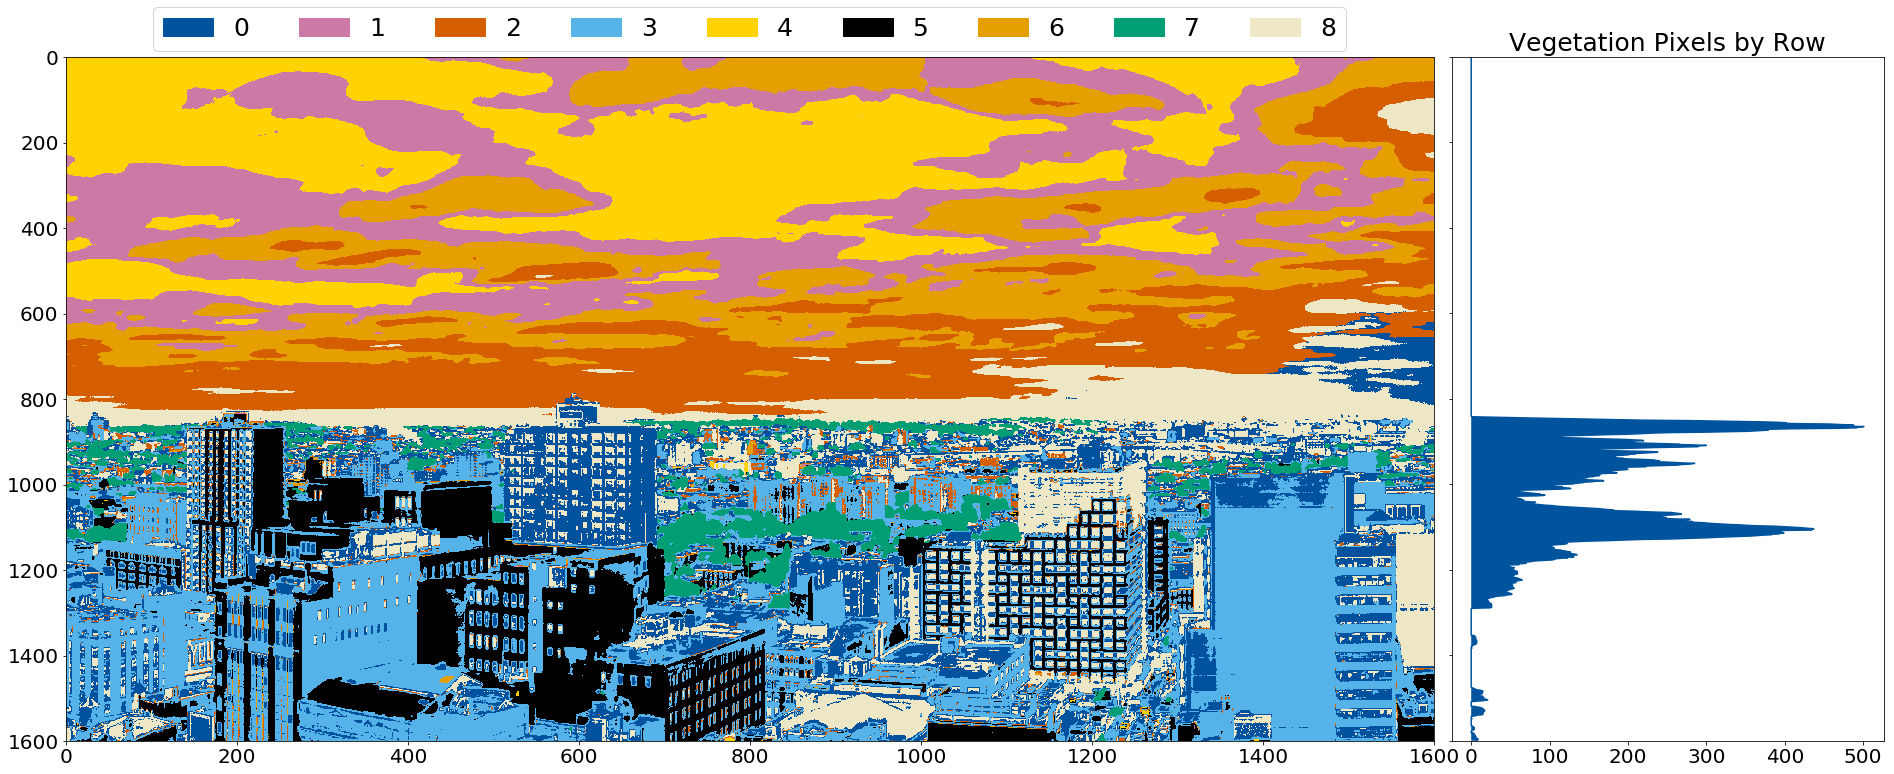

In [35]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

t=1
cmap = {0: [0,0.32549,0.62353,1], #sky: UD blue
        1: [0.8,0.47451,0.65490,1],    #metal: reddish purple
        2: [0.83529,0.36863,0,1],   #cars: vermillion
        3: [0.33725,0.70588,0.91373,1], #water: sky blue
        4: [1,0.82353,0,1],#windows: UD Gold
        5: [0,0,0,1], #built: black
        6: [0.90196,0.62353,0,1],  #roads: orange
        7: [0,0.61961,0.45098,1],  #veg: bluish green
        8: [0.93333,0.9098,0.77255,1] #clouds: UD beige
         }
labels = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'10', 11:'11'}
arrayShow = np.array([[cmap[i] for i in j] for j in labels_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
#fig, ax = plt.subplots(figsize = (20,10))

fig = plt.figure(1, figsize=(30,10))
axImage = plt.axes([0.1,0.1,0.65,0.95])
axHist = plt.axes([0.75,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0.5,1), loc=9, borderaxespad=-2.0, prop={'size':25}, ncol=12)
axHist.plot(veg_by_row, np.arange(0,cube_sub.shape[1]), color=[0.0,0.33,0.62])
axHist.fill_between(veg_by_row, np.arange(0,cube_sub.shape[1]), cube_sub.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
plt.show()
#fig.savefig("./output/plots/19_kmeans_clustering_of_veg_00108.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

### read test sample (veg_00108)

In [37]:
# read manually selected coordinates files

#sky coordinates
sky_file = open("../manual_classified_pixels/1_sky_coordinates_108.txt", "r")
sky_coords = sky_file.readlines()
sky_file.close()
sky_coords = np.array([point_from_string(line) for line in sky_coords])
print("sky:        ", sky_coords.shape)

#clouds coordinates
clouds_file = open("../manual_classified_pixels/2_clouds_coordinates_108.txt", "r")
clouds_coords = clouds_file.readlines()
clouds_file.close()
clouds_coords = np.array([point_from_string(line) for line in clouds_coords])
print("clouds:     ", clouds_coords.shape)

#vegetation coordinates
veg_file = open("../manual_classified_pixels/3_vegetation_coordinates_108.txt", "r")
veg_coords = veg_file.readlines()
veg_file.close()
veg_coords = np.array([point_from_string(line) for line in veg_coords])
print("vegetation: ", veg_coords.shape)

#water coordinates
wtr_file = open("../manual_classified_pixels/4_water_coordinates_108.txt", "r")
wtr_coords = wtr_file.readlines()
wtr_file.close()
wtr_coords = np.array([point_from_string(line) for line in wtr_coords])
print("water:      ", wtr_coords.shape)

#buildings coordinates
blt_file = open("../manual_classified_pixels/5_buildings_coordinates_108.txt", "r")
blt_coords = blt_file.readlines()
blt_file.close()
blt_coords = np.array([point_from_string(line) for line in blt_coords])
print("buildings:  ", blt_coords.shape)

#windows coordinates
windows_file = open("../manual_classified_pixels/6_windows_coordinates_108.txt", "r")
windows_coords = windows_file.readlines()
windows_file.close()
windows_coords = np.array([point_from_string(line) for line in windows_coords])
print("windows:    ", windows_coords.shape)

#roads coordinates
rds_file = open("../manual_classified_pixels/7_roads_coordinates_108.txt", "r")
rds_coords = rds_file.readlines()
rds_file.close()
rds_coords = np.array([point_from_string(line) for line in rds_coords])
print("road:       ", rds_coords.shape)

#cars coordinates
cars_file = open("../manual_classified_pixels/8_cars_coordinates_108.txt", "r")
cars_coords = cars_file.readlines()
cars_file.close()
cars_coords = np.array([point_from_string(line) for line in cars_coords])
print("cars:       ", cars_coords.shape)

#metal coordinates
mtl_file = open("../manual_classified_pixels/9_metal_coordinates_108.txt", "r")
mtl_coords = mtl_file.readlines()
mtl_file.close()
mtl_coords = np.array([point_from_string(line) for line in mtl_coords])
print("metal:      ", mtl_coords.shape)

sky:         (300, 2)
clouds:      (500, 2)
vegetation:  (600, 2)
water:       (50, 2)
buildings:   (1020, 2)
windows:     (500, 2)
road:        (30, 2)
cars:        (100, 2)
metal:       (100, 2)


#### sklearn metrics

In [38]:
labels_pred_sky = labels_reshape[sky_coords[:,0], sky_coords[:,1]]
labels_pred_clouds = labels_reshape[clouds_coords[:,0], clouds_coords[:,1]]
labels_pred_veg = labels_reshape[veg_coords[:,0], veg_coords[:,1]]
labels_pred_wtr = labels_reshape[wtr_coords[:,0], wtr_coords[:,1]]
labels_pred_blt = labels_reshape[blt_coords[:,0], blt_coords[:,1]]
labels_pred_windows = labels_reshape[windows_coords[:,0], windows_coords[:,1]]
labels_pred_rds = labels_reshape[rds_coords[:,0], rds_coords[:,1]]
labels_pred_cars = labels_reshape[cars_coords[:,0], cars_coords[:,1]]
labels_pred_mtl = labels_reshape[mtl_coords[:,0], mtl_coords[:,1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [39]:
labels_true_sky = np.full((sky_coords.shape[0]), 0)
labels_true_clouds = np.full((clouds_coords.shape[0]), 1)
labels_true_veg = np.full((veg_coords.shape[0]), 2)
labels_true_wtr = np.full((wtr_coords.shape[0]), 3)
labels_true_blt = np.full((blt_coords.shape[0]), 4)
labels_true_windows = np.full((windows_coords.shape[0]), 5)
labels_true_rds = np.full((rds_coords.shape[0]), 6)
labels_true_cars = np.full((cars_coords.shape[0]), 7)
labels_true_mtl = np.full((mtl_coords.shape[0]), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [40]:
print(labels_pred.shape)
print(labels_true.shape)

(3200,)
(3200,)


In [41]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Rand Index Adjusted for Chance")
print(metrics.adjusted_rand_score(labels_true, labels_pred))

print("")
print("Completeness, Homogeneity, V-measure")
print(metrics.homogeneity_completeness_v_measure(labels_true, labels_pred))

Confusion Matrix
[[  1   1 183   0   0   0  38   0  77]
 [  0  39   0   0 460   0   1   0   0]
 [  0   0   0   9   0   2   0 588   1]
 [  0   0   0   0   0   0   0   0  50]
 [234   0  13 345   0 386   1   0  41]
 [124   0  53  36   0   2   2   0 283]
 [ 22   0   0   8   0   0   0   0   0]
 [ 27   0  11  36   3   8   0   0  15]
 [ 51   0   0  43   0   4   0   0   2]]

Rand Index Adjusted for Chance
0.5166494554615111

Completeness, Homogeneity, V-measure
(0.660287315485192, 0.5928998546572948, 0.6247817767536099)


In [42]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(labels_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(labels_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(labels_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(labels_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(labels_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(labels_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(labels_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(labels_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(labels_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

              0   1    2    3    4    5   6    7    8
sky           1   1  183    0    0    0  38    0   77
clouds        0  39    0    0  460    0   1    0    0
vegetation    0   0    0    9    0    2   0  588    1
water         0   0    0    0    0    0   0    0   50
built       234   0   13  345    0  386   1    0   41
windows     124   0   53   36    0    2   2    0  283
roads        22   0    0    8    0    0   0    0    0
cars         27   0   11   36    3    8   0    0   15
metal        51   0    0   43    0    4   0    0    2


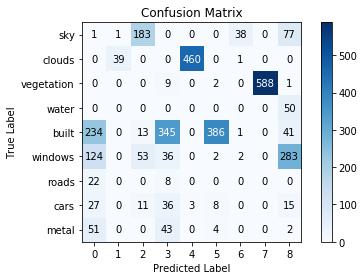

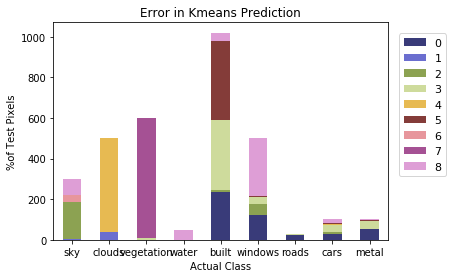

In [43]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)

---
## KMeans on veg_00000 (South Facing @ ~6pm)

In [44]:
fname0 = "../../image_files/veg_00000.raw"
cube0 = read_hyper(fname0)

reading and parsing ../../image_files/veg_00000.hdr...
reading ../../image_files/veg_00000.raw...


In [45]:
cube_sub0 = cube0.data[:, :, :].astype(float)
print(cube_sub0.shape)

(848, 1600, 1600)


In [46]:
cube_reshaped0 = cube_sub0.transpose(1, 2, 0).reshape((cube_sub0.shape[1] * cube_sub0.shape[2]), cube_sub0.shape[0])
print(cube_reshaped0.shape)

(2560000, 848)


In [47]:
cube_standard0 = (cube_reshaped0 - cube_reshaped0.mean(1, keepdims=True)) / cube_reshaped0.std(1, keepdims=True)

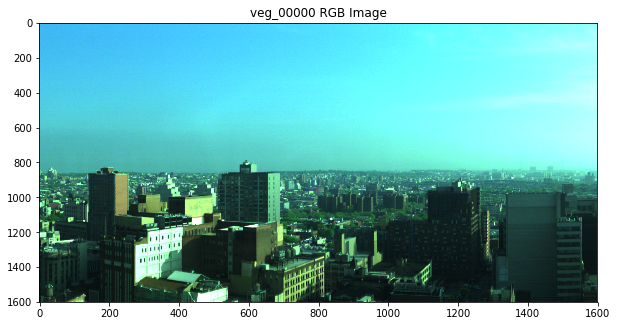

In [48]:
cube_norm0 = (cube_reshaped0 - cube_reshaped0.min()) / (cube_reshaped0.max() - cube_reshaped0.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind0 = (np.abs(cube0.waves - 650.0)).argmin()
green_ind0 = (np.abs(cube0.waves - 550.0)).argmin()
blue_ind0 = (np.abs(cube0.waves - 450.0)).argmin()

cube_reshaped02 = cube_norm0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], cube_sub0.shape[0])
cube_scene0 = cube_reshaped02[:, :, [red_ind0, green_ind0, blue_ind0]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00000 RGB Image')
ax.imshow(cube_scene0, aspect=0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


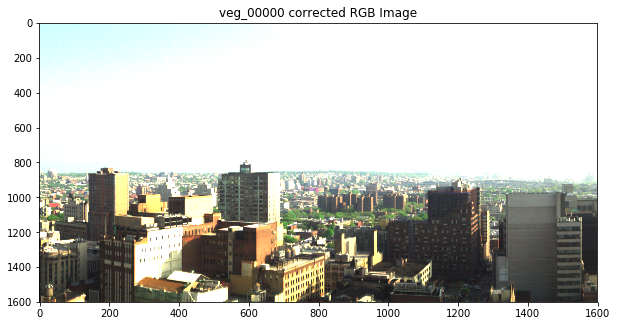

In [49]:
rgb0 = cube_reshaped02[:, :, [red_ind0, green_ind0, blue_ind0]].copy()
rgb0 /= rgb0.mean((0, 1), keepdims=True)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00000 corrected RGB Image')
ax.imshow(rgb0, aspect=0.5)
plt.show()

In [50]:
labels_std0 = kmeans.predict(cube_standard0)
labels_reshape0 = labels_std0.reshape(cube_sub0.shape[1], cube_sub0.shape[2])

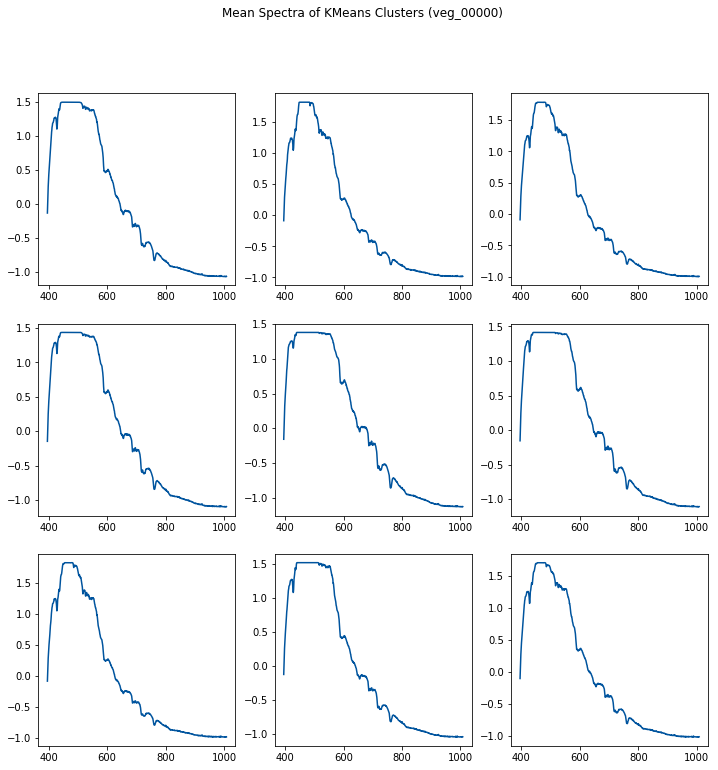

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 12))
plt.suptitle('Mean Spectra of KMeans Clusters (veg_00000)')
ax1.plot(cube0.waves, cube_standard0[np.where(labels_reshape0 == 0)[0]].mean(0), color=[0.0,0.33,0.62])
ax2.plot(cube0.waves, cube_standard0[np.where(labels_reshape0 == 1)[0]].mean(0), color=[0.0,0.33,0.62])
ax3.plot(cube0.waves, cube_standard0[np.where(labels_reshape0 == 2)[0]].mean(0), color=[0.0,0.33,0.62])
ax4.plot(cube0.waves, cube_standard0[np.where(labels_reshape0 == 3)[0]].mean(0), color=[0.0,0.33,0.62])
ax5.plot(cube0.waves, cube_standard0[np.where(labels_reshape0 == 4)[0]].mean(0), color=[0.0,0.33,0.62])
ax6.plot(cube0.waves, cube_standard0[np.where(labels_reshape0 == 5)[0]].mean(0), color=[0.0,0.33,0.62])
ax7.plot(cube0.waves, cube_standard0[np.where(labels_reshape0 == 6)[0]].mean(0), color=[0.0,0.33,0.62])
ax8.plot(cube0.waves, cube_standard0[np.where(labels_reshape0 == 7)[0]].mean(0), color=[0.0,0.33,0.62])
ax9.plot(cube0.waves, cube_standard0[np.where(labels_reshape0 == 8)[0]].mean(0), color=[0.0,0.33,0.62])
plt.show()
#f.savefig("./output/plots/13_kmeans_cluster_centers_spectra_standardized_4_clusters.png")

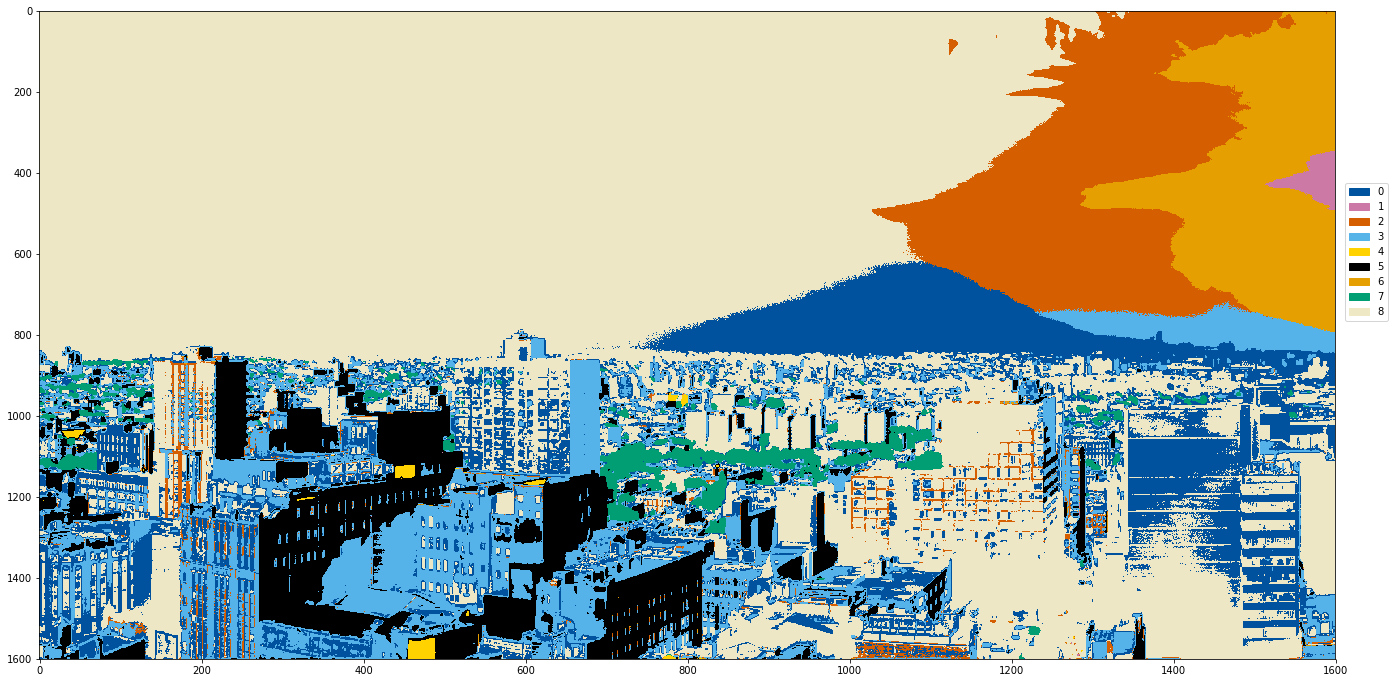

In [52]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

t=1
cmap = {0: [0,0.32549,0.62353,1], #sky: UD blue
        1: [0.8,0.47451,0.65490,1],    #metal: reddish purple
        2: [0.83529,0.36863,0,1],   #cars: vermillion
        3: [0.33725,0.70588,0.91373,1], #water: sky blue
        4: [1,0.82353,0,1],#windows: UD Gold
        5: [0,0,0,1], #built: black
        6: [0.90196,0.62353,0,1],  #roads: orange
        7: [0,0.61961,0.45098,1],  #veg: bluish green
        8: [0.93333,0.9098,0.77255,1] #clouds: UD beige
         }
labels = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'10', 11:'11'}
arrayShow = np.array([[cmap[i] for i in j] for j in labels_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(30,10))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', 
                borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./output/plots/19_kmeans_clustering_of_veg_00108.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [53]:
veg_by_row0 = np.zeros(cube_sub0.shape[1])
for row in range(0, cube_sub0.shape[1]):
    veg_by_row0[row] = np.count_nonzero(labels_reshape0[row,:] == 7)# + np.count_nonzero(labels_reshape[row,:] == 8) + np.count_nonzero(labels_reshape[row,:] == 9)

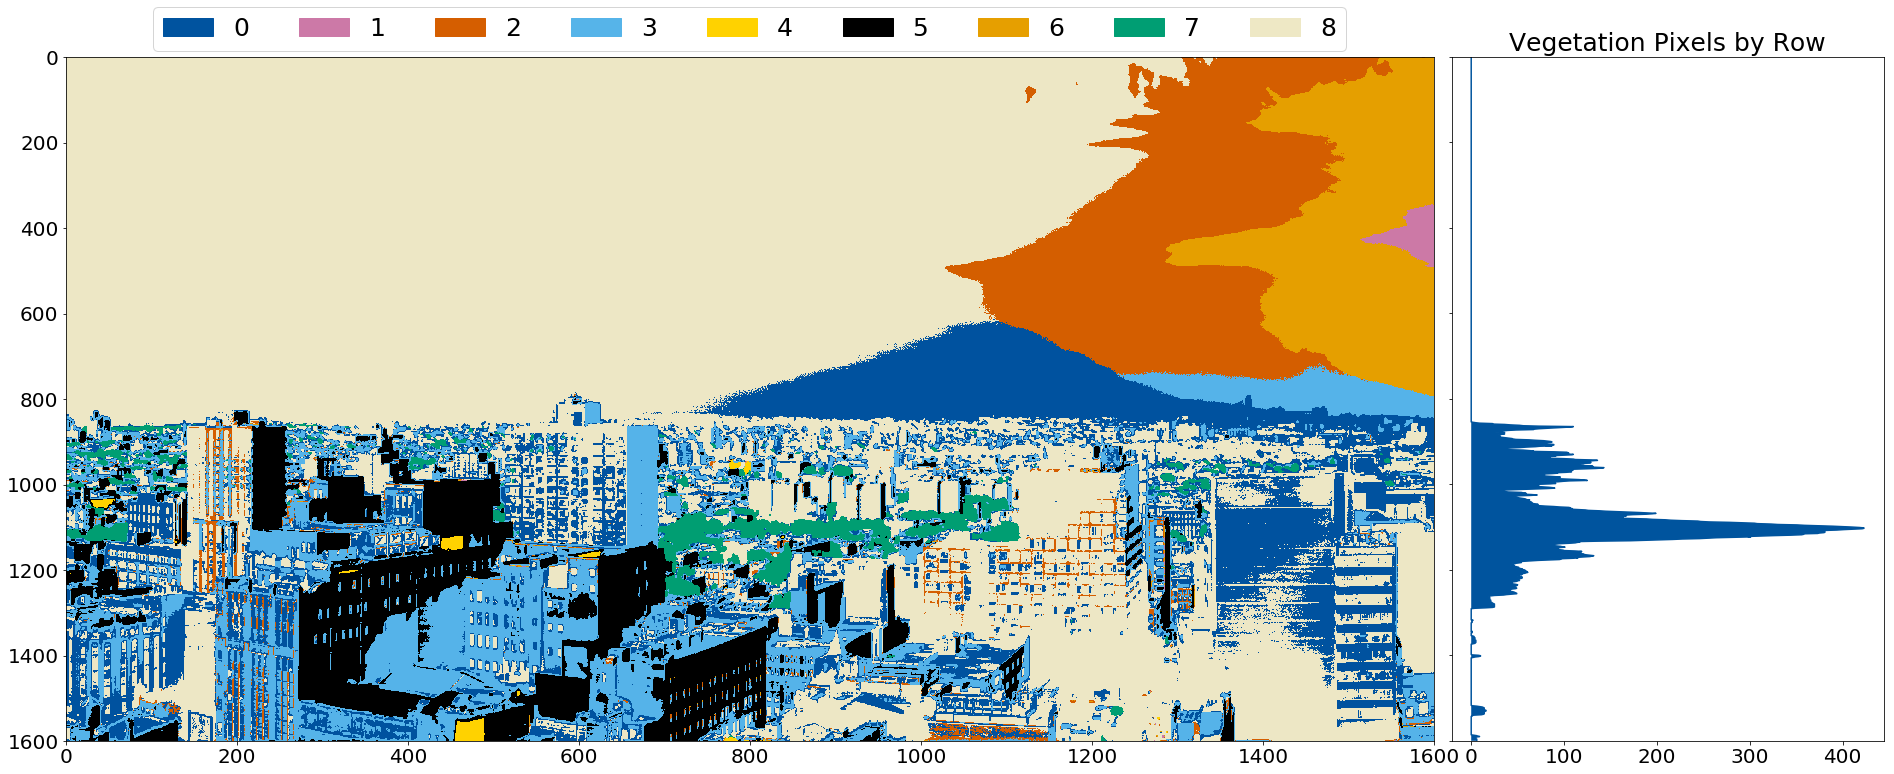

In [54]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

t=1
cmap = {0: [0,0.32549,0.62353,1], #sky: UD blue
        1: [0.8,0.47451,0.65490,1],    #metal: reddish purple
        2: [0.83529,0.36863,0,1],   #cars: vermillion
        3: [0.33725,0.70588,0.91373,1], #water: sky blue
        4: [1,0.82353,0,1],#windows: UD Gold
        5: [0,0,0,1], #built: black
        6: [0.90196,0.62353,0,1],  #roads: orange
        7: [0,0.61961,0.45098,1],  #veg: bluish green
        8: [0.93333,0.9098,0.77255,1] #clouds: UD beige
         }
labels = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'10', 11:'11'}
arrayShow = np.array([[cmap[i] for i in j] for j in labels_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
#fig, ax = plt.subplots(figsize = (20,10))

fig = plt.figure(1, figsize=(30,10))
axImage = plt.axes([0.1,0.1,0.65,0.95])
axHist = plt.axes([0.75,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0.5,1), loc=9, borderaxespad=-2.0, prop={'size':25}, ncol=12)
axHist.plot(veg_by_row0, np.arange(0,cube_sub.shape[1]), color=[0.0,0.33,0.62])
axHist.fill_between(veg_by_row0, np.arange(0,cube_sub.shape[1]), cube_sub.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
plt.show()
#fig.savefig("./output/plots/19_kmeans_clustering_of_veg_00108.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

### read test sample (veg_00000)

In [56]:
# read manually selected coordinates files

#sky coordinates
sky_file0 = open("../manual_classified_pixels/1_sky_coordinates_000.txt", "r")
sky_coords0 = sky_file0.readlines()
sky_file0.close()
sky_coords0 = np.array([point_from_string(line) for line in sky_coords0])
print("sky:        ", sky_coords0.shape)

#clouds coordinates
clouds_file0 = open("../manual_classified_pixels/2_clouds_coordinates_000.txt", "r")
clouds_coords0 = clouds_file0.readlines()
clouds_file0.close()
clouds_coords0 = np.array([point_from_string(line) for line in clouds_coords0])
print("clouds:     ", clouds_coords0.shape)

#vegetation coordinates
veg_file0 = open("../manual_classified_pixels/3_vegetation_coordinates_000.txt", "r")
veg_coords0 = veg_file0.readlines()
veg_file0.close()
veg_coords0 = np.array([point_from_string(line) for line in veg_coords0])
print("vegetation: ", veg_coords0.shape)

#water coordinates
wtr_file0 = open("../manual_classified_pixels/4_water_coordinates_000.txt", "r")
wtr_coords0 = wtr_file0.readlines()
wtr_file0.close()
wtr_coords0 = np.array([point_from_string(line) for line in wtr_coords0])
print("water:      ", wtr_coords0.shape)

#buildings coordinates
blt_file0 = open("../manual_classified_pixels/5_buildings_coordinates_000.txt", "r")
blt_coords0 = blt_file0.readlines()
blt_file0.close()
blt_coords0 = np.array([point_from_string(line) for line in blt_coords0])
print("buildings:  ", blt_coords0.shape)

#windows coordinates
windows_file0 = open("../manual_classified_pixels/6_windows_coordinates_000.txt", "r")
windows_coords0 = windows_file0.readlines()
windows_file0.close()
windows_coords0 = np.array([point_from_string(line) for line in windows_coords0])
print("windows:    ", windows_coords0.shape)

#roads coordinates
rds_file0 = open("../manual_classified_pixels/7_roads_coordinates_000.txt", "r")
rds_coords0 = rds_file0.readlines()
rds_file0.close()
rds_coords0 = np.array([point_from_string(line) for line in rds_coords0])
print("road:       ", rds_coords0.shape)

#cars coordinates
cars_file0 = open("../manual_classified_pixels/8_cars_coordinates_000.txt", "r")
cars_coords0 = cars_file0.readlines()
cars_file0.close()
cars_coords0 = np.array([point_from_string(line) for line in cars_coords0])
print("cars:       ", cars_coords0.shape)

#metal coordinates
mtl_file0 = open("../manual_classified_pixels/9_metal_coordinates_000.txt", "r")
mtl_coords0 = mtl_file0.readlines()
mtl_file0.close()
mtl_coords0 = np.array([point_from_string(line) for line in mtl_coords0])
print("metal:      ", mtl_coords0.shape)

sky:         (400, 2)
clouds:      (500, 2)
vegetation:  (610, 2)
water:       (0,)
buildings:   (1200, 2)
windows:     (500, 2)
road:        (60, 2)
cars:        (55, 2)
metal:       (230, 2)


In [57]:
wtr_coords0=np.array([[0,0]])

#### sklearn metrics

In [58]:
labels0_pred_sky = labels_reshape0[sky_coords0[:,0], sky_coords0[:,1]]
labels0_pred_clouds = labels_reshape0[clouds_coords0[:,0], clouds_coords0[:,1]]
labels0_pred_veg = labels_reshape0[veg_coords0[:,0], veg_coords0[:,1]]
labels0_pred_wtr = labels_reshape0[wtr_coords0[:,0], wtr_coords0[:,1]]
labels0_pred_blt = labels_reshape0[blt_coords0[:,0], blt_coords0[:,1]]
labels0_pred_windows = labels_reshape0[windows_coords0[:,0], windows_coords0[:,1]]
labels0_pred_rds = labels_reshape0[rds_coords0[:,0], rds_coords0[:,1]]
labels0_pred_cars = labels_reshape0[cars_coords0[:,0], cars_coords0[:,1]]
labels0_pred_mtl = labels_reshape0[mtl_coords0[:,0], mtl_coords0[:,1]]

labels0_pred = np.concatenate((labels0_pred_sky, labels0_pred_clouds, labels0_pred_veg, labels0_pred_wtr, 
                             labels0_pred_blt, labels0_pred_windows, labels0_pred_rds, labels0_pred_cars, labels0_pred_mtl))

In [59]:
labels0_true_sky = np.full((sky_coords0.shape[0]), 0)
labels0_true_clouds = np.full((clouds_coords0.shape[0]), 1)
labels0_true_veg = np.full((veg_coords0.shape[0]), 2)
labels0_true_wtr = np.full((wtr_coords0.shape[0]), 3)
labels0_true_blt = np.full((blt_coords0.shape[0]), 4)
labels0_true_windows = np.full((windows_coords0.shape[0]), 5)
labels0_true_rds = np.full((rds_coords0.shape[0]), 6)
labels0_true_cars = np.full((cars_coords0.shape[0]), 7)
labels0_true_mtl = np.full((mtl_coords0.shape[0]), 8)

labels0_true = np.concatenate((labels0_true_sky, labels0_true_clouds, labels0_true_veg, labels0_true_wtr, 
                             labels0_true_blt, labels0_true_windows, labels0_true_rds, labels0_true_cars, labels0_true_mtl))

In [60]:
print(labels0_pred.shape)
print(labels0_true.shape)

(3556,)
(3556,)


In [62]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels0_true, labels0_pred))

print("")
print("Rand Index Adjusted for Chance")
print(metrics.adjusted_rand_score(labels0_true, labels0_pred))

print("")
print("Completeness, Homogeneity, V-measure")
print(metrics.homogeneity_completeness_v_measure(labels0_true, labels0_pred))

Confusion Matrix
[[  0   0   0   0   0   0   0   0 400]
 [ 27   5 175  14   0   0 124   0 155]
 [ 16   0   0   2   0   3   0 539  50]
 [  0   0   0   0   0   0   0   0   1]
 [267   0   0 248   8 616   0   0  61]
 [108   0  43 147   0  49   8   3 142]
 [  0   0   0   0   0   0   0   0  60]
 [  0   0   0   0   0   0   0   0  55]
 [ 75   0   0  88   0  51   0   0  16]]

Rand Index Adjusted for Chance
0.3445193444754054

Completeness, Homogeneity, V-measure
(0.47832496238948485, 0.4656871047599857, 0.47192143961083305)


In [63]:
sky_dict0, sky_dict_norm0 = kmeans_test_dictionary(labels_reshape0, sky_coords0, 9)
clouds_dict0, cloud_dict_norm0 = kmeans_test_dictionary(labels_reshape0, clouds_coords0, 9)
veg_dict0, veg_dict_norm0 = kmeans_test_dictionary(labels_reshape0, veg_coords0, 9)
wtr_dict0, wtr_dict_norm0 = kmeans_test_dictionary(labels_reshape0, wtr_coords0, 9)
blt_dict0, blt_dict_norm0 = kmeans_test_dictionary(labels_reshape0, blt_coords0, 9)
windows_dict0, windows_dict_norm0 = kmeans_test_dictionary(labels_reshape0, windows_coords0, 9)
rds_dict0, rds_dict_norm0 = kmeans_test_dictionary(labels_reshape0, rds_coords0, 9)
cars_dict0, cars_dict_norm0 = kmeans_test_dictionary(labels_reshape0, cars_coords0, 9)
mtl_dict0, mtl_dict_norm0 = kmeans_test_dictionary(labels_reshape0, mtl_coords0, 9)

df_test0 = kmeans_test_dataframe(sky_dict0, clouds_dict0, veg_dict0, wtr_dict0,
                                blt_dict0, windows_dict0, rds_dict0, cars_dict0, mtl_dict0)
print(df_test0.transpose())
df_test_norm0 = kmeans_test_dataframe(sky_dict0, clouds_dict0, veg_dict0, wtr_dict0,
                                     blt_dict0, windows_dict0, rds_dict0, cars_dict0, mtl_dict0)
#print("")
#print(df_test_norm0.transpose())

              0  1    2    3  4    5    6    7    8
sky           0  0    0    0  0    0    0    0  400
clouds       27  5  175   14  0    0  124    0  155
vegetation   16  0    0    2  0    3    0  539   50
water         0  0    0    0  0    0    0    0    1
built       267  0    0  248  8  616    0    0   61
windows     108  0   43  147  0   49    8    3  142
roads         0  0    0    0  0    0    0    0   60
cars          0  0    0    0  0    0    0    0   55
metal        75  0    0   88  0   51    0    0   16


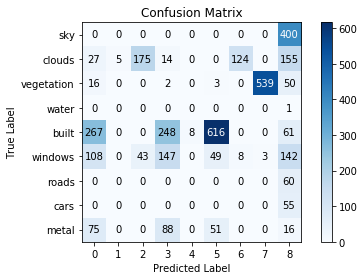

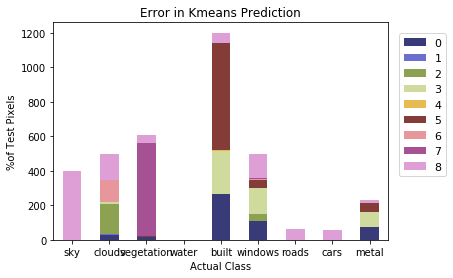

In [64]:
plot_confusion_matrix(df_test0, norm=False)
#plot_confusion_matrix(df_test_norm0, norm=True)
plot_test_result(df_test_norm0)

---
## KMeans on North Facing Image

In [65]:
fname_north = "../../image_files/scan1_slow_roof_VNIR.raw"
cube_north = read_hyper(fname_north)

reading and parsing ../../image_files/scan1_slow_roof_VNIR.hdr...
reading ../../image_files/scan1_slow_roof_VNIR.raw...


In [66]:
cube_sub_north = cube_north.data[:, :, :].astype(float)
print(cube_sub_north.shape)

(872, 1600, 1247)


In [67]:
cube_reshaped_north = cube_sub_north.transpose(1, 2, 0).reshape((cube_sub_north.shape[1] * cube_sub_north.shape[2]), cube_sub_north.shape[0])
print(cube_reshaped_north.shape)

(1995200, 872)


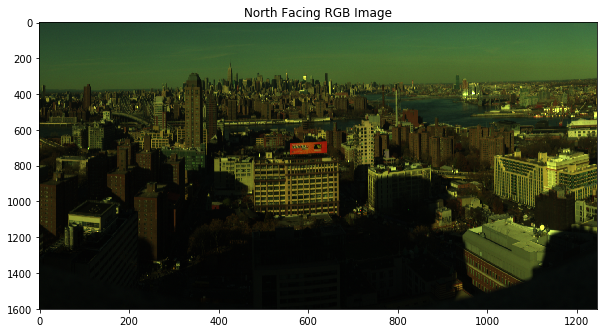

In [68]:
cube_norm_north = (cube_reshaped_north - cube_reshaped_north.min()) / (cube_reshaped_north.max() - cube_reshaped_north.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind_n = (np.abs(cube_north.waves - 650.0)).argmin()
green_ind_n = (np.abs(cube_north.waves - 550.0)).argmin()
blue_ind_n = (np.abs(cube_north.waves - 450.0)).argmin()

cube_reshaped_north2 = cube_norm_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], cube_sub_north.shape[0])
cube_scene_north = cube_reshaped_north2[:, :, [red_ind_n, green_ind_n, blue_ind_n]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('North Facing RGB Image')
ax.imshow(cube_scene_north, aspect=0.4)
plt.show()

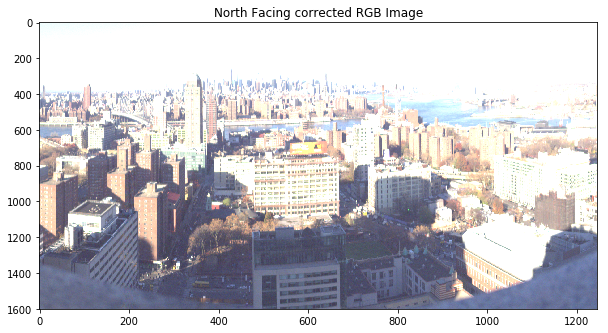

In [69]:
rgbn = cube_reshaped_north2[:, :, [red_ind_n, green_ind_n, blue_ind_n]].copy()
rgbn /= rgbn.mean((0, 1), keepdims=True)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('North Facing corrected RGB Image')
ax.imshow(rgbn.clip(0, 1)**0.5, aspect=0.4)
plt.show()

In [70]:
cube_standard_north = (cube_reshaped_north - cube_reshaped_north.mean(1, keepdims=True)) / cube_reshaped_north.std(1, keepdims=True)
cube_reshaped_north = cube_standard_north

In [71]:
print(len(cube.waves))
print(min(cube.waves), max(cube.waves))
print()
print(len(cube_north.waves))
print(min(cube_north.waves), max(cube_north.waves))

848
395.46 1008.06

872
400.46 1031.29


In [72]:
# interpolating an extrapolating the north facing scene

from scipy.interpolate import interp1d

interp_hsi = interp1d(cube_north.waves, cube_reshaped_north, axis=1, fill_value="extrapolate")
northri = interp_hsi(cube.waves)

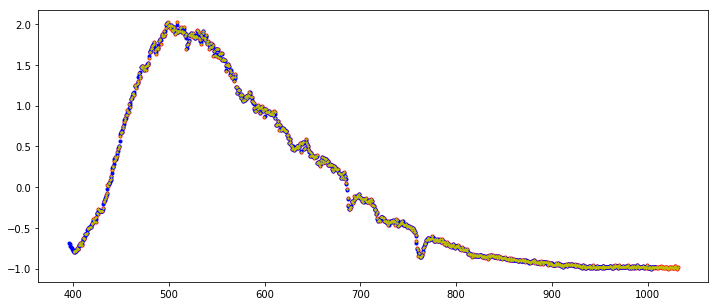

In [73]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(cube_north.waves, cube_reshaped_north[1000, :], ".", color="r")
ax.plot(cube.waves, northri[1000, :], 'o', ms=3, color="b")
ax.plot(cube_north.waves, cube_reshaped_north[1000, :], ".", ms=3, color="y")

In [74]:
print(cube_reshaped_north.shape)
print(northri.shape)

(1995200, 872)
(1995200, 848)


In [75]:
labels_north = kmeans.predict(northri)
labels_reshape_north = labels_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


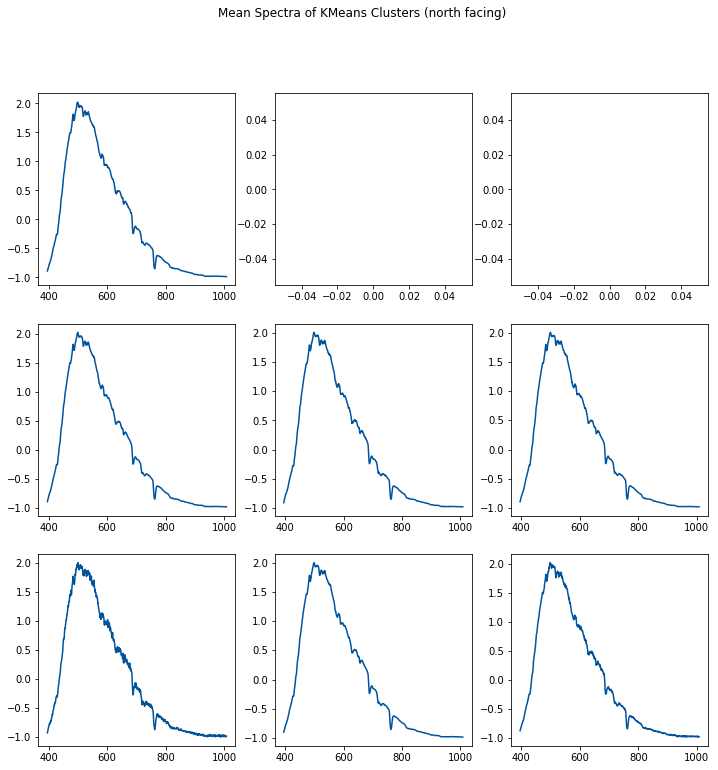

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 12))
plt.suptitle('Mean Spectra of KMeans Clusters (north facing)')
ax1.plot(cube.waves, northri[np.where(labels_reshape_north == 0)[0]].mean(0), color=[0.0,0.33,0.62])
ax2.plot(cube.waves, northri[np.where(labels_reshape_north == 1)[0]].mean(0), color=[0.0,0.33,0.62])
ax3.plot(cube.waves, northri[np.where(labels_reshape_north == 2)[0]].mean(0), color=[0.0,0.33,0.62])
ax4.plot(cube.waves, northri[np.where(labels_reshape_north == 3)[0]].mean(0), color=[0.0,0.33,0.62])
ax5.plot(cube.waves, northri[np.where(labels_reshape_north == 4)[0]].mean(0), color=[0.0,0.33,0.62])
ax6.plot(cube.waves, northri[np.where(labels_reshape_north == 5)[0]].mean(0), color=[0.0,0.33,0.62])
ax7.plot(cube.waves, northri[np.where(labels_reshape_north == 6)[0]].mean(0), color=[0.0,0.33,0.62])
ax8.plot(cube.waves, northri[np.where(labels_reshape_north == 7)[0]].mean(0), color=[0.0,0.33,0.62])
ax9.plot(cube.waves, northri[np.where(labels_reshape_north == 8)[0]].mean(0), color=[0.0,0.33,0.62])
plt.show()
#f.savefig("./output/plots/13_kmeans_cluster_centers_spectra_standardized_4_clusters.png")

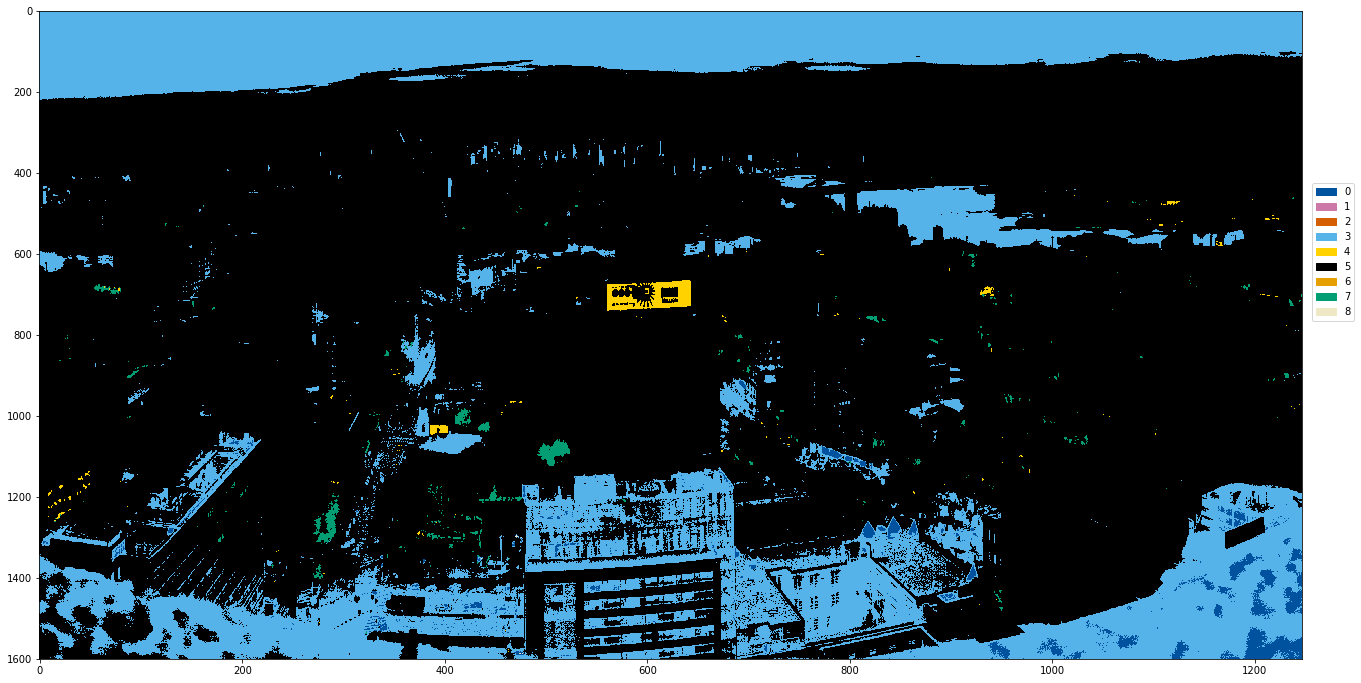

In [77]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

t=1
cmap = {0: [0,0.32549,0.62353,1], #sky: UD blue
        1: [0.8,0.47451,0.65490,1],    #metal: reddish purple
        2: [0.83529,0.36863,0,1],   #cars: vermillion
        3: [0.33725,0.70588,0.91373,1], #water: sky blue
        4: [1,0.82353,0,1],#windows: UD Gold
        5: [0,0,0,1], #built: black
        6: [0.90196,0.62353,0,1],  #roads: orange
        7: [0,0.61961,0.45098,1],  #veg: bluish green
        8: [0.93333,0.9098,0.77255,1] #clouds: UD beige
         }
labels = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'10', 11:'11'}
arrayShow = np.array([[cmap[i] for i in j] for j in labels_reshape_north])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(30,10))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.4)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', 
                borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./output/plots/19_kmeans_clustering_of_veg_00108.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [78]:
veg_by_row_north = np.zeros(cube_sub_north.shape[1])
for row in range(0, cube_sub_north.shape[1]):
    veg_by_row_north[row] = np.count_nonzero(labels_reshape_north[row,:] == 7)

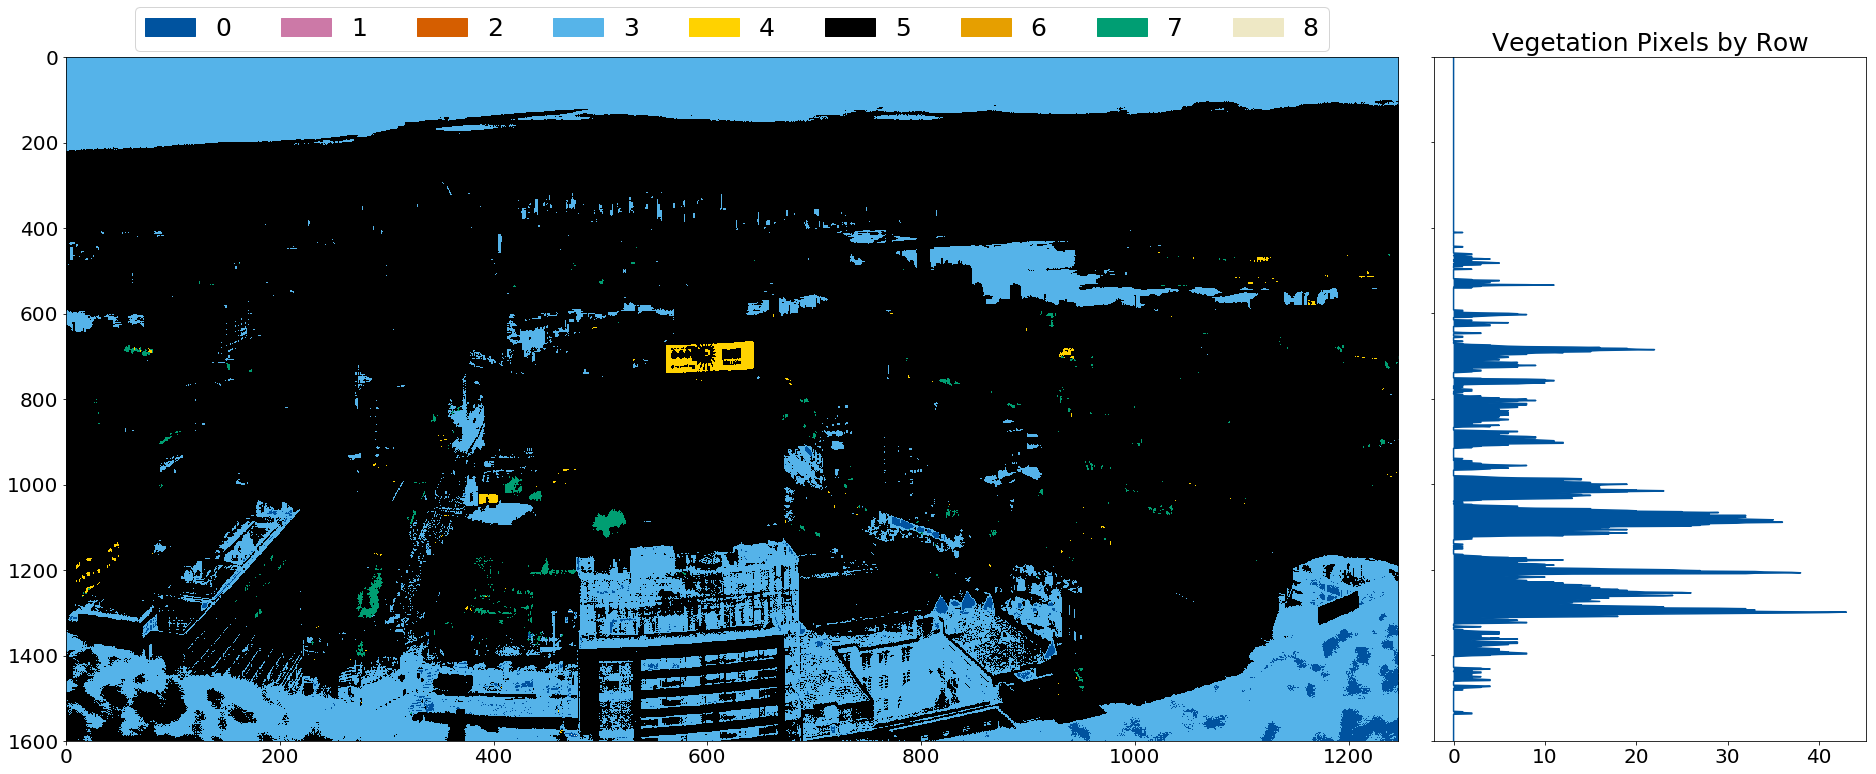

In [79]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

t=1
cmap = {0: [0,0.32549,0.62353,1], #sky: UD blue
        1: [0.8,0.47451,0.65490,1],    #metal: reddish purple
        2: [0.83529,0.36863,0,1],   #cars: vermillion
        3: [0.33725,0.70588,0.91373,1], #water: sky blue
        4: [1,0.82353,0,1],#windows: UD Gold
        5: [0,0,0,1], #built: black
        6: [0.90196,0.62353,0,1],  #roads: orange
        7: [0,0.61961,0.45098,1],  #veg: bluish green
        8: [0.93333,0.9098,0.77255,1] #clouds: UD beige
         }
labels = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'10', 11:'11'}
arrayShow = np.array([[cmap[i] for i in j] for j in labels_reshape_north])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
#fig, ax = plt.subplots(figsize = (20,10))

fig = plt.figure(1, figsize=(30,10))
axImage = plt.axes([0.1,0.1,0.65,0.95])
axHist = plt.axes([0.75,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.4)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0.5,1), loc=9, borderaxespad=-2.0, prop={'size':25}, ncol=12)
axHist.plot(veg_by_row_north, np.arange(0,cube_sub_north.shape[1]), color=[0.0,0.33,0.62])
axHist.fill_between(veg_by_row_north, np.arange(0,cube_sub_north.shape[1]), cube_sub_north.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub_north.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
plt.show()
#fig.savefig("./output/plots/19_kmeans_clustering_of_veg_00108.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

### read test sample (north facing)

In [81]:
# read manually selected coordinates files

#sky coordinates
sky_filen = open("../manual_classified_pixels/1_sky_coordinates_north.txt", "r")
sky_coordsn = sky_filen.readlines()
sky_filen.close()
sky_coordsn = np.array([point_from_string(line) for line in sky_coordsn])
print("sky:        ", sky_coordsn.shape)

#clouds coordinates
clouds_filen = open("../manual_classified_pixels/2_clouds_coordinates_north.txt", "r")
clouds_coordsn = clouds_filen.readlines()
clouds_filen.close()
clouds_coordsn = np.array([point_from_string(line) for line in clouds_coordsn])
print("clouds:     ", clouds_coordsn.shape)

#vegetation coordinates
veg_filen = open("../manual_classified_pixels/3_vegetation_coordinates_north.txt", "r")
veg_coordsn = veg_filen.readlines()
veg_filen.close()
veg_coordsn = np.array([point_from_string(line) for line in veg_coordsn])
print("vegetation: ", veg_coordsn.shape)

#water coordinates
wtr_filen = open("../manual_classified_pixels/4_water_coordinates_north.txt", "r")
wtr_coordsn = wtr_filen.readlines()
wtr_filen.close()
wtr_coordsn = np.array([point_from_string(line) for line in wtr_coordsn])
print("water:      ", wtr_coordsn.shape)

#buildings coordinates
blt_filen = open("../manual_classified_pixels/5_buildings_coordinates_north.txt", "r")
blt_coordsn = blt_filen.readlines()
blt_filen.close()
blt_coordsn = np.array([point_from_string(line) for line in blt_coordsn])
print("buildings:  ", blt_coordsn.shape)

#windows coordinates
windows_filen = open("../manual_classified_pixels/6_windows_coordinates_north.txt", "r")
windows_coordsn = windows_filen.readlines()
windows_filen.close()
windows_coordsn = np.array([point_from_string(line) for line in windows_coordsn])
print("windows:    ", windows_coordsn.shape)

#roads coordinates
rds_filen = open("../manual_classified_pixels/7_roads_coordinates_north.txt", "r")
rds_coordsn = rds_filen.readlines()
rds_filen.close()
rds_coordsn = np.array([point_from_string(line) for line in rds_coordsn])
print("road:       ", rds_coordsn.shape)

#cars coordinates
cars_filen = open("../manual_classified_pixels/8_cars_coordinates_north.txt", "r")
cars_coordsn = cars_filen.readlines()
cars_filen.close()
cars_coordsn = np.array([point_from_string(line) for line in cars_coordsn])
print("cars:       ", cars_coordsn.shape)

#metal coordinates
mtl_filen = open("../manual_classified_pixels/9_metal_coordinates_north.txt", "r")
mtl_coordsn = mtl_filen.readlines()
mtl_filen.close()
mtl_coordsn = np.array([point_from_string(line) for line in mtl_coordsn])
print("metal:      ", mtl_coordsn.shape)

sky:         (300, 2)
clouds:      (200, 2)
vegetation:  (700, 2)
water:       (620, 2)
buildings:   (1600, 2)
windows:     (600, 2)
road:        (250, 2)
cars:        (250, 2)
metal:       (185, 2)


#### sklearn metrics

In [82]:
labelsn_pred_sky = labels_reshape_north[sky_coordsn[:,0], sky_coordsn[:,1]]
labelsn_pred_clouds = labels_reshape_north[clouds_coordsn[:,0], clouds_coordsn[:,1]]
labelsn_pred_veg = labels_reshape_north[veg_coordsn[:,0], veg_coordsn[:,1]]
labelsn_pred_wtr = labels_reshape_north[wtr_coordsn[:,0], wtr_coordsn[:,1]]
labelsn_pred_blt = labels_reshape_north[blt_coordsn[:,0], blt_coordsn[:,1]]
labelsn_pred_windows = labels_reshape_north[windows_coordsn[:,0], windows_coordsn[:,1]]
labelsn_pred_rds = labels_reshape_north[rds_coordsn[:,0], rds_coordsn[:,1]]
labelsn_pred_cars = labels_reshape_north[cars_coordsn[:,0], cars_coordsn[:,1]]
labelsn_pred_mtl = labels_reshape_north[mtl_coordsn[:,0], mtl_coordsn[:,1]]

labelsn_pred = np.concatenate((labelsn_pred_sky, labelsn_pred_clouds, labelsn_pred_veg, labelsn_pred_wtr, 
                             labelsn_pred_blt, labelsn_pred_windows, labelsn_pred_rds, labelsn_pred_cars, labelsn_pred_mtl))

In [83]:
labelsn_true_sky = np.full((sky_coordsn.shape[0]), 0)
labelsn_true_clouds = np.full((clouds_coordsn.shape[0]), 1)
labelsn_true_veg = np.full((veg_coordsn.shape[0]), 2)
labelsn_true_wtr = np.full((wtr_coordsn.shape[0]), 3)
labelsn_true_blt = np.full((blt_coordsn.shape[0]), 4)
labelsn_true_windows = np.full((windows_coordsn.shape[0]), 5)
labelsn_true_rds = np.full((rds_coordsn.shape[0]), 6)
labelsn_true_cars = np.full((cars_coordsn.shape[0]), 7)
labelsn_true_mtl = np.full((mtl_coordsn.shape[0]), 8)

labelsn_true = np.concatenate((labelsn_true_sky, labelsn_true_clouds, labelsn_true_veg, labelsn_true_wtr, 
                             labelsn_true_blt, labelsn_true_windows, labelsn_true_rds, labelsn_true_cars, labelsn_true_mtl))

In [84]:
print(labelsn_pred.shape)
print(labelsn_true.shape)

(4705,)
(4705,)


In [85]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labelsn_true, labelsn_pred))

print("")
print("Rand Index Adjusted for Chance")
print(metrics.adjusted_rand_score(labelsn_true, labelsn_pred))

print("")
print("Completeness, Homogeneity, V-measure")
print(metrics.homogeneity_completeness_v_measure(labelsn_true, labelsn_pred))

Confusion Matrix
[[   0    0    0  300    0    0    0    0    0]
 [   0    0    0    0    0  200    0    0    0]
 [   0    0    0    0    6  647    0   47    0]
 [   0    0    0  360    0  260    0    0    0]
 [  10    0    0  188    0 1402    0    0    0]
 [   0    0    0   72    0  527    0    1    0]
 [   4    0    0  104    0  142    0    0    0]
 [  15    0    0   38    1  196    0    0    0]
 [   0    0    0    4    0  181    0    0    0]]

Rand Index Adjusted for Chance
0.09281605217933953

Completeness, Homogeneity, V-measure
(0.12384187312257765, 0.37559352733660417, 0.18626715653442222)


In [86]:
sky_dictn, sky_dict_normn = kmeans_test_dictionary(labels_reshape_north, sky_coordsn, 9)
clouds_dictn, cloud_dict_normn = kmeans_test_dictionary(labels_reshape_north, clouds_coordsn, 9)
veg_dictn, veg_dict_normn = kmeans_test_dictionary(labels_reshape_north, veg_coordsn, 9)
wtr_dictn, wtr_dict_normn = kmeans_test_dictionary(labels_reshape_north, wtr_coordsn, 9)
blt_dictn, blt_dict_normn = kmeans_test_dictionary(labels_reshape_north, blt_coordsn, 9)
windows_dictn, windows_dict_normn = kmeans_test_dictionary(labels_reshape_north, windows_coordsn, 9)
rds_dictn, rds_dict_normn = kmeans_test_dictionary(labels_reshape_north, rds_coordsn, 9)
cars_dictn, cars_dict_normn = kmeans_test_dictionary(labels_reshape_north, cars_coordsn, 9)
mtl_dictn, mtl_dict_normn = kmeans_test_dictionary(labels_reshape_north, mtl_coordsn, 9)

df_testn = kmeans_test_dataframe(sky_dictn, clouds_dictn, veg_dictn, wtr_dictn,
                                blt_dictn, windows_dictn, rds_dictn, cars_dictn, mtl_dictn)
print(df_testn.transpose())
df_test_normn = kmeans_test_dataframe(sky_dictn, clouds_dictn, veg_dictn, wtr_dictn,
                                     blt_dictn, windows_dictn, rds_dictn, cars_dictn, mtl_dictn)
#print("")
#print(df_test_normn.transpose())

             0  1  2    3  4     5  6   7  8
sky          0  0  0  300  0     0  0   0  0
clouds       0  0  0    0  0   200  0   0  0
vegetation   0  0  0    0  6   647  0  47  0
water        0  0  0  360  0   260  0   0  0
built       10  0  0  188  0  1402  0   0  0
windows      0  0  0   72  0   527  0   1  0
roads        4  0  0  104  0   142  0   0  0
cars        15  0  0   38  1   196  0   0  0
metal        0  0  0    4  0   181  0   0  0


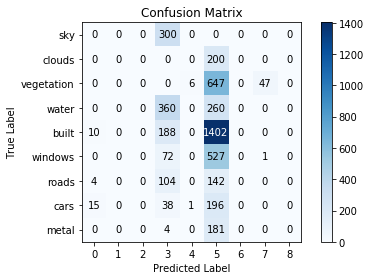

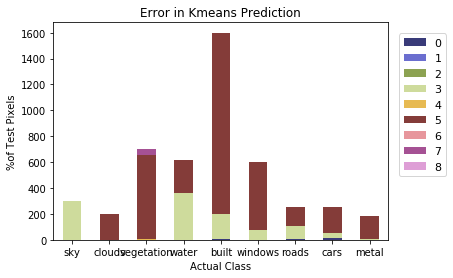

In [87]:
plot_confusion_matrix(df_testn, norm=False)
#plot_confusion_matrix(df_test_normn, norm=True)
plot_test_result(df_test_normn)